In [1]:
import json
import pandas as pd
from thefuzz import fuzz
from thefuzz import process
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import seaborn as sns
from IPython.display import display, HTML
from Levenshtein import distance as lev
from collections import defaultdict
import time
import matplotlib.pyplot as plt


f = open('validation_set.json',)
validation_df = json.load(f)
print("validation set size: {}".format(len(validation_df)))

flavor_df = json.load(open('flavor_DB.json',))
flavorlist=[]
for i in range(len(flavor_df)):
    flavorlist.append(flavor_df[i]['entity_alias_readable']) 
    
print("# of unique flavors: {}".format(len(flavorlist)))

validation set size: 100
# of unique flavors: 934


In [2]:
#String match class. 
class stringmatch(object):
    def __init__(self, flavor_df):
        self.flavorlist=[]
        for i in range(len(flavor_df)):
            self.flavorlist.append(flavor_df[i]['entity_alias_readable']) 
    def shortenstring(self,text,i):
        return (','.join(text.split(',')[:i]))
    def flavormatch0(self,ingredient, xlimit=1):
        #print("input ingredient: {}".format(ingredient))
        match = process.extract(ingredient, self.flavorlist, limit=xlimit)
        #print("best matches: {}".format(match))
        return match
    def flavormatch1(self,ingredient, xlimit=1):
        ingredient_s=self.shortenstring(ingredient,1)
        match = process.extract(ingredient_s, self.flavorlist, limit=xlimit)
        return match
    def flavormatch2(self,ingredient, xlimit=1):
        ingredient_s=self.shortenstring(ingredient,2)
        match = process.extract(ingredient_s, self.flavorlist, limit=xlimit)
        return match
    def flavormatch3(self,ingredient, xlimit=1):
        ingredient_s=self.shortenstring(ingredient,3)
        match = process.extract(ingredient_s, self.flavorlist, limit=xlimit)
        return match
    def flavormatch4(self,ingredient, xlimit=1):
        match = process.extract(ingredient, self.flavorlist, limit=xlimit, scorer=fuzz.token_sort_ratio)
        return match
    def flavormatch5(self,ingredient, xlimit=1):
        match = process.extract(ingredient, self.flavorlist, limit=xlimit, scorer=fuzz.token_set_ratio)
        return match
    def to_list(self,validation_df):  #input is validation_df
        val_set=[]
        val_labels=[]
        for i in validation_df:
            for j in i['ingredients']:
                val_set.append(j['text'])
            for j in i['ingredients_flavormatch']:
                val_labels.append(j['text'])
        return val_set,val_labels
    def accuracy(self,val_set, alg, zlimit):
        compare = pd.DataFrame(
            {'input': val_set,
            'actual labels': val_labels})
        compare['index']= compare.index
        val_predictions=[]
        sa=str(alg)
        for i in val_set:
            if alg==0:
                val_predictions.append(z.flavormatch0(i,zlimit)) 
            elif alg==1:
                val_predictions.append(z.flavormatch1(i,zlimit)) 
            elif alg==2:
                val_predictions.append(z.flavormatch2(i,zlimit)) 
            elif alg==3:
                val_predictions.append(z.flavormatch3(i,zlimit)) 
            elif alg==4:
                val_predictions.append(z.flavormatch4(i,zlimit)) 
            elif alg==5:
                val_predictions.append(z.flavormatch5(i,zlimit)) 

        for i in range(zlimit):
            compare[sa+str(i)+"pred"]=compare["index"].apply(lambda x: val_predictions[x][i][0])
        compare[sa+"_match?"]=compare.drop("actual labels", 1).isin(compare["actual labels"]).any(1)
        compare[sa+"_match?"]=compare[sa+"_match?"].astype(int)
        acc=compare[sa+"_match?"].sum()/len(compare[sa+"_match?"])
        display(HTML(compare.head(5).to_html()))
        return acc

In [3]:
#computes accuracies for input string, chosen algorithm and top k matches. does it in pandas dataframe form
#cell can take a few minutes to run. due to having to search all unique flavors
z=stringmatch(flavor_df)
val_set,val_labels=z.to_list(validation_df)
acc0=[z.accuracy(val_set,0,1),z.accuracy(val_set,0,2),z.accuracy(val_set,0,3),z.accuracy(val_set,0,4)]


,input,actual labels,index,00pred,0_match?
0,"wheat flour, white, all-purpose, unenriched",Flour,0,White Bread,0
1,"leavening agents, baking soda",Leavening agent,1,Leavening agent,1
2,"butter, without salt",Butter,2,Butter,1
3,"cream, sour, cultured",Cream,3,Cream,1
4,"corn, sweet, white, raw",Corn,4,Corn,1


,input,actual labels,index,00pred,01pred,0_match?
0,"wheat flour, white, all-purpose, unenriched",Flour,0,White Bread,White Wine,0
1,"leavening agents, baking soda",Leavening agent,1,Leavening agent,Nuts,1
2,"butter, without salt",Butter,2,Butter,Salt,1
3,"cream, sour, cultured",Cream,3,Cream,Cream Cheese,1
4,"corn, sweet, white, raw",Corn,4,Corn,White Bread,1


,input,actual labels,index,00pred,01pred,02pred,0_match?
0,"wheat flour, white, all-purpose, unenriched",Flour,0,White Bread,White Wine,White Currant,0
1,"leavening agents, baking soda",Leavening agent,1,Leavening agent,Nuts,Lingcod,1
2,"butter, without salt",Butter,2,Butter,Salt,Peanut Butter,1
3,"cream, sour, cultured",Cream,3,Cream,Cream Cheese,Sour Cherry,1
4,"corn, sweet, white, raw",Corn,4,Corn,White Bread,White Wine,1


,input,actual labels,index,00pred,01pred,02pred,03pred,0_match?
0,"wheat flour, white, all-purpose, unenriched",Flour,0,White Bread,White Wine,White Currant,White Pepper,0
1,"leavening agents, baking soda",Leavening agent,1,Leavening agent,Nuts,Lingcod,Beaver,1
2,"butter, without salt",Butter,2,Butter,Salt,Peanut Butter,Cocoa butter,1
3,"cream, sour, cultured",Cream,3,Cream,Cream Cheese,Sour Cherry,Ice cream,1
4,"corn, sweet, white, raw",Corn,4,Corn,White Bread,White Wine,Corn Oil,1


In [4]:
acc1=[z.accuracy(val_set,1,1),z.accuracy(val_set,1,2),z.accuracy(val_set,1,3),z.accuracy(val_set,1,4)]

,input,actual labels,index,10pred,1_match?
0,"wheat flour, white, all-purpose, unenriched",Flour,0,Wheat,0
1,"leavening agents, baking soda",Leavening agent,1,Leavening agent,1
2,"butter, without salt",Butter,2,Butter,1
3,"cream, sour, cultured",Cream,3,Cream,1
4,"corn, sweet, white, raw",Corn,4,Corn,1


,input,actual labels,index,10pred,11pred,1_match?
0,"wheat flour, white, all-purpose, unenriched",Flour,0,Wheat,Flour,1
1,"leavening agents, baking soda",Leavening agent,1,Leavening agent,Sage,1
2,"butter, without salt",Butter,2,Butter,Buttermilk,1
3,"cream, sour, cultured",Cream,3,Cream,Cream Cheese,1
4,"corn, sweet, white, raw",Corn,4,Corn,Corn Oil,1


,input,actual labels,index,10pred,11pred,12pred,1_match?
0,"wheat flour, white, all-purpose, unenriched",Flour,0,Wheat,Flour,Meat,1
1,"leavening agents, baking soda",Leavening agent,1,Leavening agent,Sage,Nuts,1
2,"butter, without salt",Butter,2,Butter,Buttermilk,Peanut Butter,1
3,"cream, sour, cultured",Cream,3,Cream,Cream Cheese,Ice cream,1
4,"corn, sweet, white, raw",Corn,4,Corn,Corn Oil,Popcorn,1


,input,actual labels,index,10pred,11pred,12pred,13pred,1_match?
0,"wheat flour, white, all-purpose, unenriched",Flour,0,Wheat,Flour,Meat,Whey,1
1,"leavening agents, baking soda",Leavening agent,1,Leavening agent,Sage,Nuts,Gin,1
2,"butter, without salt",Butter,2,Butter,Buttermilk,Peanut Butter,Giant butterbur,1
3,"cream, sour, cultured",Cream,3,Cream,Cream Cheese,Ice cream,Soy cream,1
4,"corn, sweet, white, raw",Corn,4,Corn,Corn Oil,Popcorn,Sweetcorn,1


In [20]:
##This can take some time to run.
acc2=[z.accuracy(val_set,2,1),z.accuracy(val_set,2,2),z.accuracy(val_set,2,3),z.accuracy(val_set,2,4)]
acc3=[z.accuracy(val_set,3,1),z.accuracy(val_set,3,2),z.accuracy(val_set,3,3),z.accuracy(val_set,3,4)]
acc4=[z.accuracy(val_set,4,1),z.accuracy(val_set,4,2),z.accuracy(val_set,4,3),z.accuracy(val_set,4,4)]
acc5=[z.accuracy(val_set,5,1),z.accuracy(val_set,5,2),z.accuracy(val_set,5,3),z.accuracy(val_set,5,4)]

NameError: name 'shortenstring' is not defined

In [5]:
#plot calculated accuracies

x=[1,2,3,4]
labels=['Weighted Ratio','Weighted Ratio truncated 1','Weighted Ratio truncated 2','Weighted Ratio truncated 3','Token Sorted Ratio','Token Set Ratio']
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams["figure.figsize"] = (6,6)
SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 14
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.plot(x,acc0, '-o')
plt.plot(x,acc1, '-s')
plt.plot(x,acc2, '-^')
plt.plot(x,acc3, '-X')
plt.plot(x,acc4, '-D')
plt.plot(x,acc5, '-*')
plt.xticks(x)
plt.legend(labels)
plt.ylabel('accuracy')
plt.xlabel('k nearest')


NameError: name 'acc2' is not defined

In [6]:
##build predictions with flavormatch2 (best algorithm)
#this cell can take a few minutes
val_predictions=[]
for i in val_set:
    val_predictions.append(z.flavormatch2(i)[0][0])
len(val_predictions)

626

<AxesSubplot:>

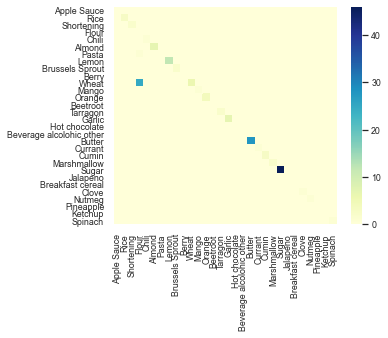

In [16]:
#Build confusion matrix with subset of matches

%matplotlib inline

unique=list(set(val_labels))+list(set(val_predictions)-set(val_labels))
unique.insert(3,'Flour')
unique.insert(10,'Wheat')
showmatches=30
cm=confusion_matrix(val_predictions, val_labels,labels=unique[:showmatches])

sns.set(rc = {'figure.figsize':(5,4)})
sns.set(font_scale = 0.8)
sns.heatmap(cm, cmap="YlGnBu",xticklabels=unique[:showmatches], yticklabels=unique[:showmatches])